# Molecular Dynamics Simulation

(c) 2008-2020 Benjamin E. Niehoff and José-Raúl González Alonso<br>
Adapted for MSE358 by Kyle D. Miller, James M. Rondinelli, and Jonathan D. Emery

## Introduction

In this project, we simulate various phases of Argon using a simplified Lennard-Jones model.  Each Ar atom is assumed to have no internal degrees of freedom, but is treated a pointlike particle interacting with the other particles in the simulation according to the Lennard-Jones "6-12" potential

\begin{equation}
U_{ij} = 4 \epsilon \bigg[ \bigg( \frac{\sigma}{r_{ij}} \bigg)^{12} - \bigg( \frac{\sigma}{r_{ij}} \bigg)^{6} \bigg].
\end{equation}

The simulation uses dimensionless parameters in which all fundamental physical constants have been absorbed.  Quantities are measured in terms of the following:

\begin{align}
&\text{Length} : \sigma = 3.405 \times 10^{-10} \, \mathrm{m}, & &\text{Time} : \tau = \sqrt{\frac{m_\text{Ar} \sigma^2}{\epsilon}} = 2.15 \times 10^{-12} \, \mathrm{s}, \\
&\text{Energy} : \epsilon = 1.65 \times 10^{-21} \, \mathrm{J}, & &\text{Temperature} : \frac{\epsilon}{k_\text{B}} = 120 \, \mathrm{K}, \\
&\text{Mass} : m_\text{Ar} = 6.63 \times 10^{-26} \, \mathrm{kg}, & &\text{Entropy} : k_\text{B} = 1.38 \times 10^{-23} \, \mathrm{J} / \mathrm{K},
\end{align}

and etc. for derived quantities such as velocities and forces.  The data files output by `md-simulate` are all in dimensionless units, so they can be rescaled with the above numbers, or with some other set of numbers in order to represent any material that can be well-approximated with the Lennard-Jones potential.  Note that the *time step* used in the simulation (and output in the `time_series.csv` files) is $0.005 \tau$, so that 200 time steps make up one unit of time.

## Setup

In [85]:
%matplotlib inline
import matplotlib_inline; matplotlib_inline.backend_inline.set_matplotlib_formats('png')  #grainy but fast
import matplotlib as mpl; mpl.rcParams['figure.dpi'] = 300 #less grainy
import os
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from rdfpy import rdf

# Below we load data from pre-run MD simulations so we can focus on the analysis
dataset_path = 'data_cellcount_14'

print("Below are the normalized density and temperature points available in the dataset.")
density_labels = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print(density_labels)

temperature_labels = [t for t in os.listdir(os.path.join(dataset_path, density_labels[0]))
                      if os.path.isdir(os.path.join(dataset_path, density_labels[0], t))]
print(temperature_labels)

Below are the normalized density and temperature points available in the dataset.
['rho_0.500', 'rho_0.600', 'rho_0.700', 'rho_0.800', 'rho_0.900', 'rho_1.000']
['T_0.100', 'T_0.150', 'T_0.200', 'T_0.250', 'T_0.300', 'T_0.350', 'T_0.400', 'T_0.450', 'T_0.500', 'T_0.550', 'T_0.600', 'T_0.650', 'T_0.700', 'T_0.750', 'T_0.800', 'T_0.850', 'T_0.900']


Load the corresponding measurement data files:

In [86]:
thermo_meas_data = pd.read_csv(os.path.join(dataset_path, 'thermo_measurements.csv'))

# Drop some extraneous rows from an incomplete run
thermo_meas_data = thermo_meas_data[thermo_meas_data['Density'] <= 1.0]

final_state_data = {d : {} for d in density_labels}
summary_info_data = {d : {} for d in density_labels}
time_series_data = {d : {} for d in density_labels}

for d in density_labels:
    for t in temperature_labels:
        final_state_data[d][t] = pd.read_csv(os.path.join(dataset_path, d, t, 'final_state.csv'))
        summary_info_data[d][t] = pd.read_csv(os.path.join(dataset_path, d, t, 'summary_info.csv'))
        time_series_data[d][t] = pd.read_csv(os.path.join(dataset_path, d, t, 'time_series.csv'),
                                            index_col='TimeStep')

## Summary Info Data

In [87]:
summary_info_data['rho_0.800']['T_0.600']

,CellCount,SideLength,AtomCount,BlockCount,BlocksPerSide,BlockLength
0,14,23.93966,10976,0,9,2.659963


The summary info just tells us some basic information about each individual run.  This run was done with 10976 particles in a box of dimensions 23.93966 cubed.  It is divided into 9 "blocks" on each side, giving a total of 9 * 9 * 9 = 729 Blocks (the BlockCount variable is never actually used in the program, so this column is reporting incorrectly).

The algorithm runs by dividing the total volume into Blocks, and processing the pairwise Lennard-Jones forces in each Block separately (in principle this could be parallelized).  The size of a Block is chosen so that particles in a given Block can only interact with other particles in the same Block, *or* within the 8 Blocks immediately adjacent to it.  Since the Lennard-Jones potential decays quickly, we can effectively ignore the interactions with any Blocks further away.  By using this strategy of assuming that only nearby particles can actually influence a given particle's motion, we can improve our performance scaling on very large simulations.

### Final State Data
Details about the final state for each simulation are stored in a dataframe accessible through the `final_state_data` dictionary.

In [93]:
final_state_data['rho_0.800']['T_0.600']

,PosX,PosY,PosZ,VelX,VelY,VelZ,Speed
0,23.316900,22.356960,1.190235,0.493001,-0.455278,1.248431,1.417360
1,23.861470,0.194281,1.547141,-0.290545,0.254016,0.237752,0.453284
2,22.772310,1.422489,0.311353,1.030434,-0.121488,-1.136349,1.538780
3,21.282440,1.518541,1.955187,-1.155520,0.161636,-0.171019,1.179237
4,1.230914,0.116651,0.523431,0.110411,0.917084,-0.605976,1.104735
...,...,...,...,...,...,...,...
10971,20.719450,23.236420,22.758700,1.118747,-1.739975,0.408655,2.108579
10972,21.869040,21.010970,21.690670,1.139486,0.597450,0.061070,1.288062
10973,1.638701,23.153390,0.009757,0.175939,-1.142084,0.818939,1.416323
10974,23.461260,22.895900,23.871910,-0.610983,-0.027420,-0.127830,0.624814


### Time Series Data
Details from the simulation recorded at each time step are stored in a dataframe accessible through the `time_series_data` dictionary.

In [95]:
time_series_data['rho_0.800']['T_0.600']

,Temp,PotEnergy,TotEnergy,MeanSqDisp
TimeStep,,,,
0,0.599447,-0.000592,-0.000510,0.006708
1,0.597770,-0.000592,-0.000510,0.013410
2,0.594920,-0.000591,-0.000510,0.020100
3,0.590811,-0.000591,-0.000510,0.026770
4,0.585328,-0.000590,-0.000510,0.033413
...,...,...,...,...
6995,0.568744,-0.000517,-0.000439,2.478333
6996,0.568491,-0.000517,-0.000439,2.478524
6997,0.568313,-0.000517,-0.000439,2.478712


## Visualization Functions
Below we provide example functions for plotting relevant data from the MD simulations.

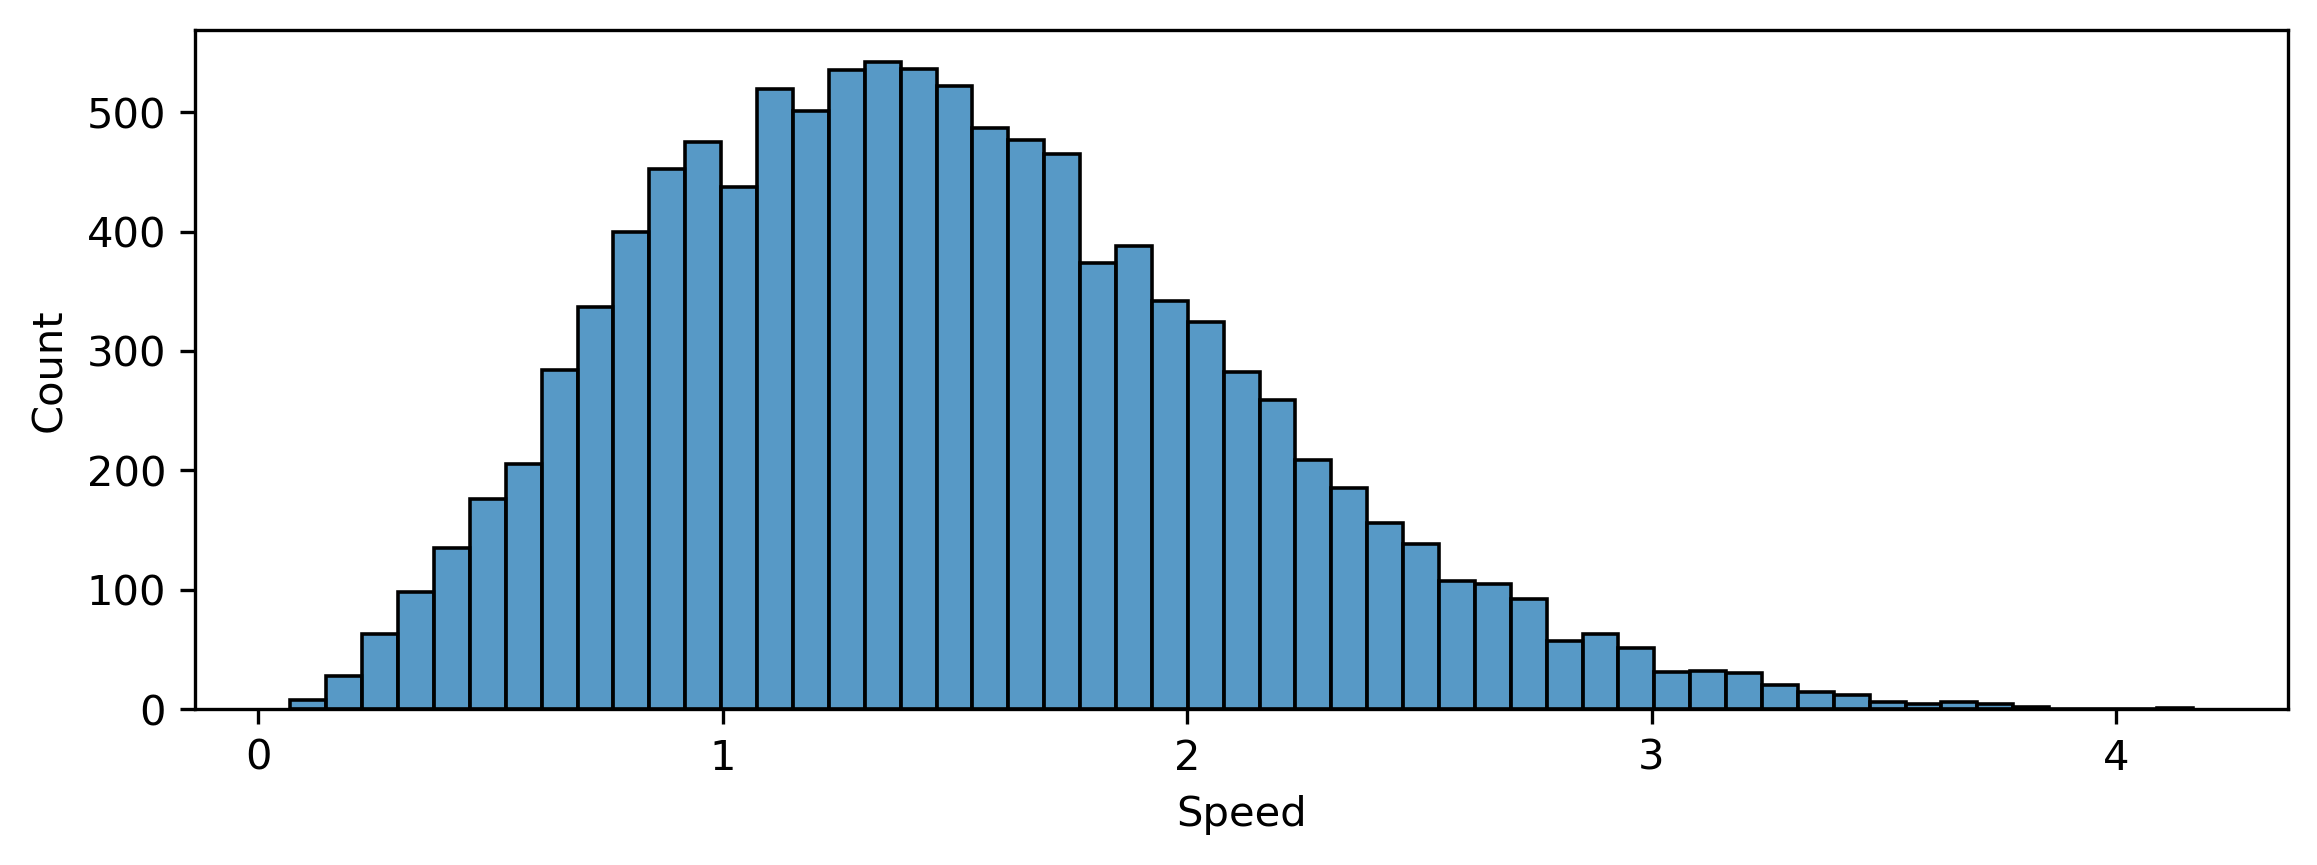

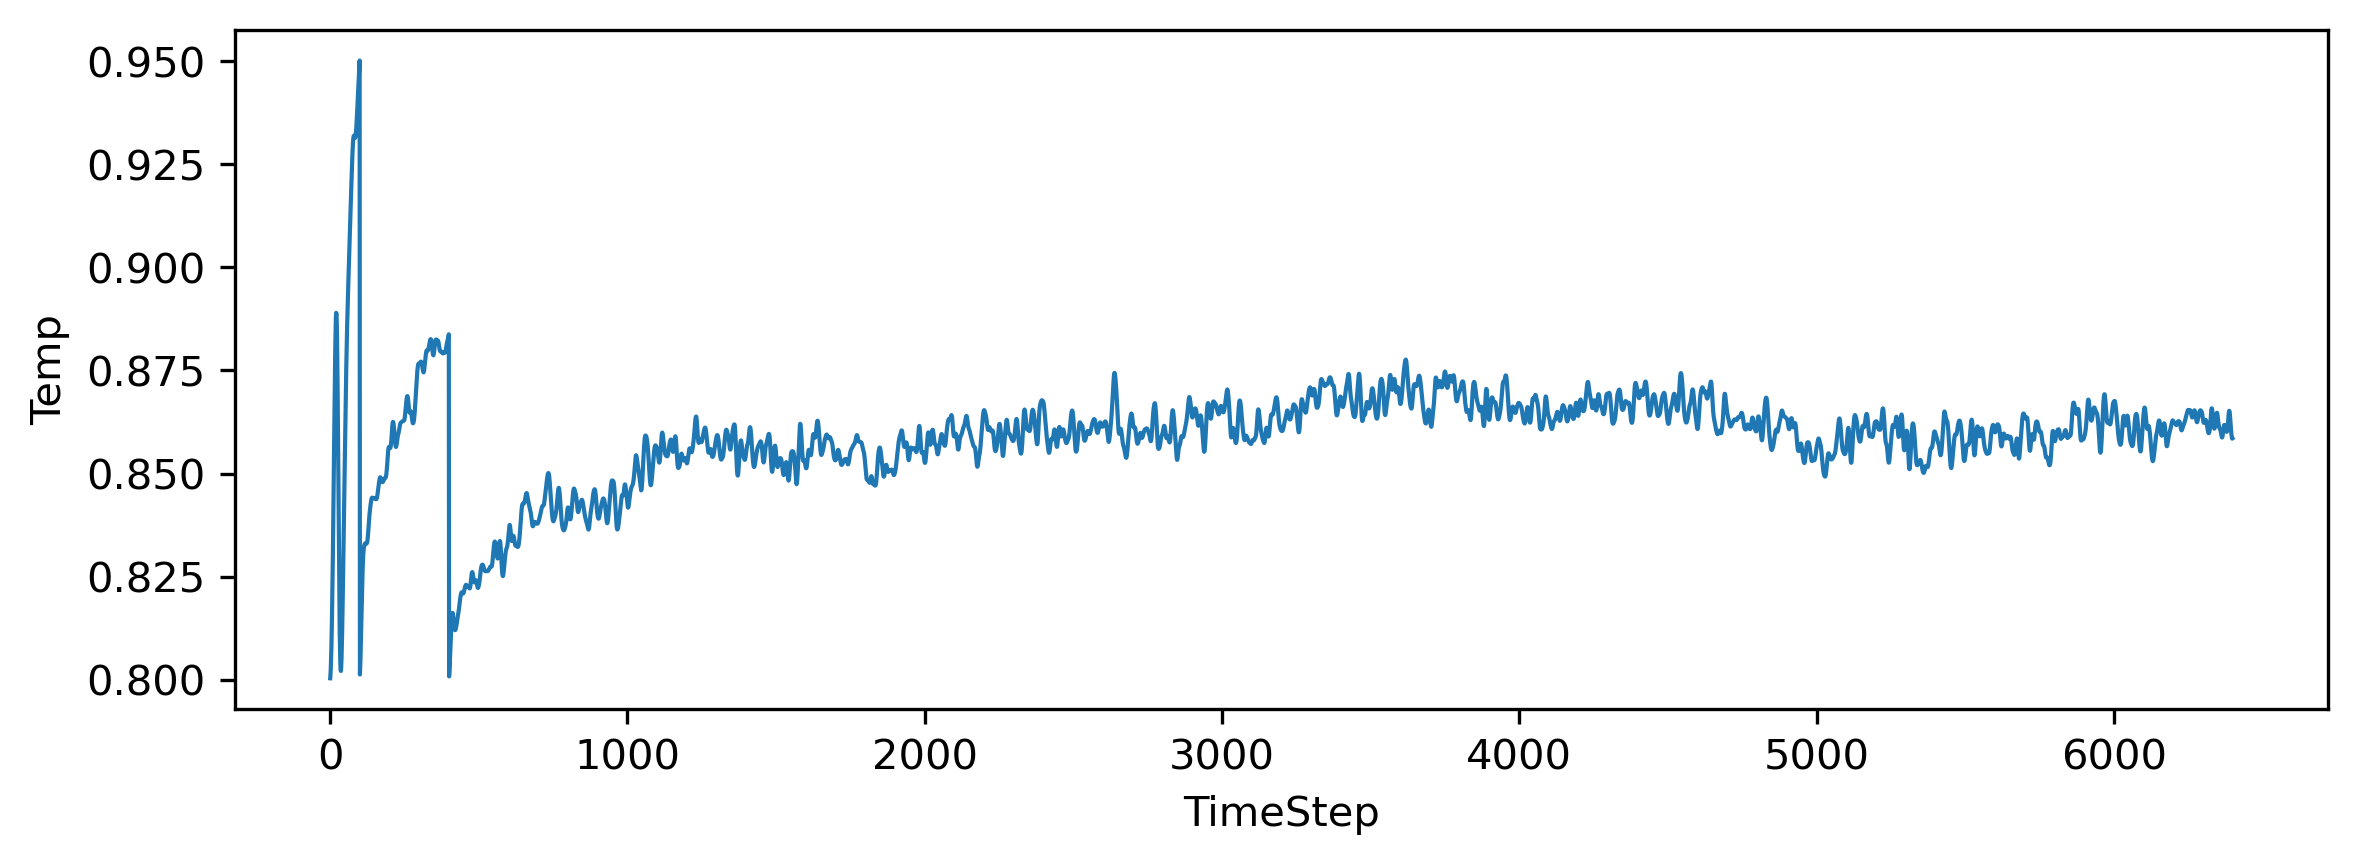

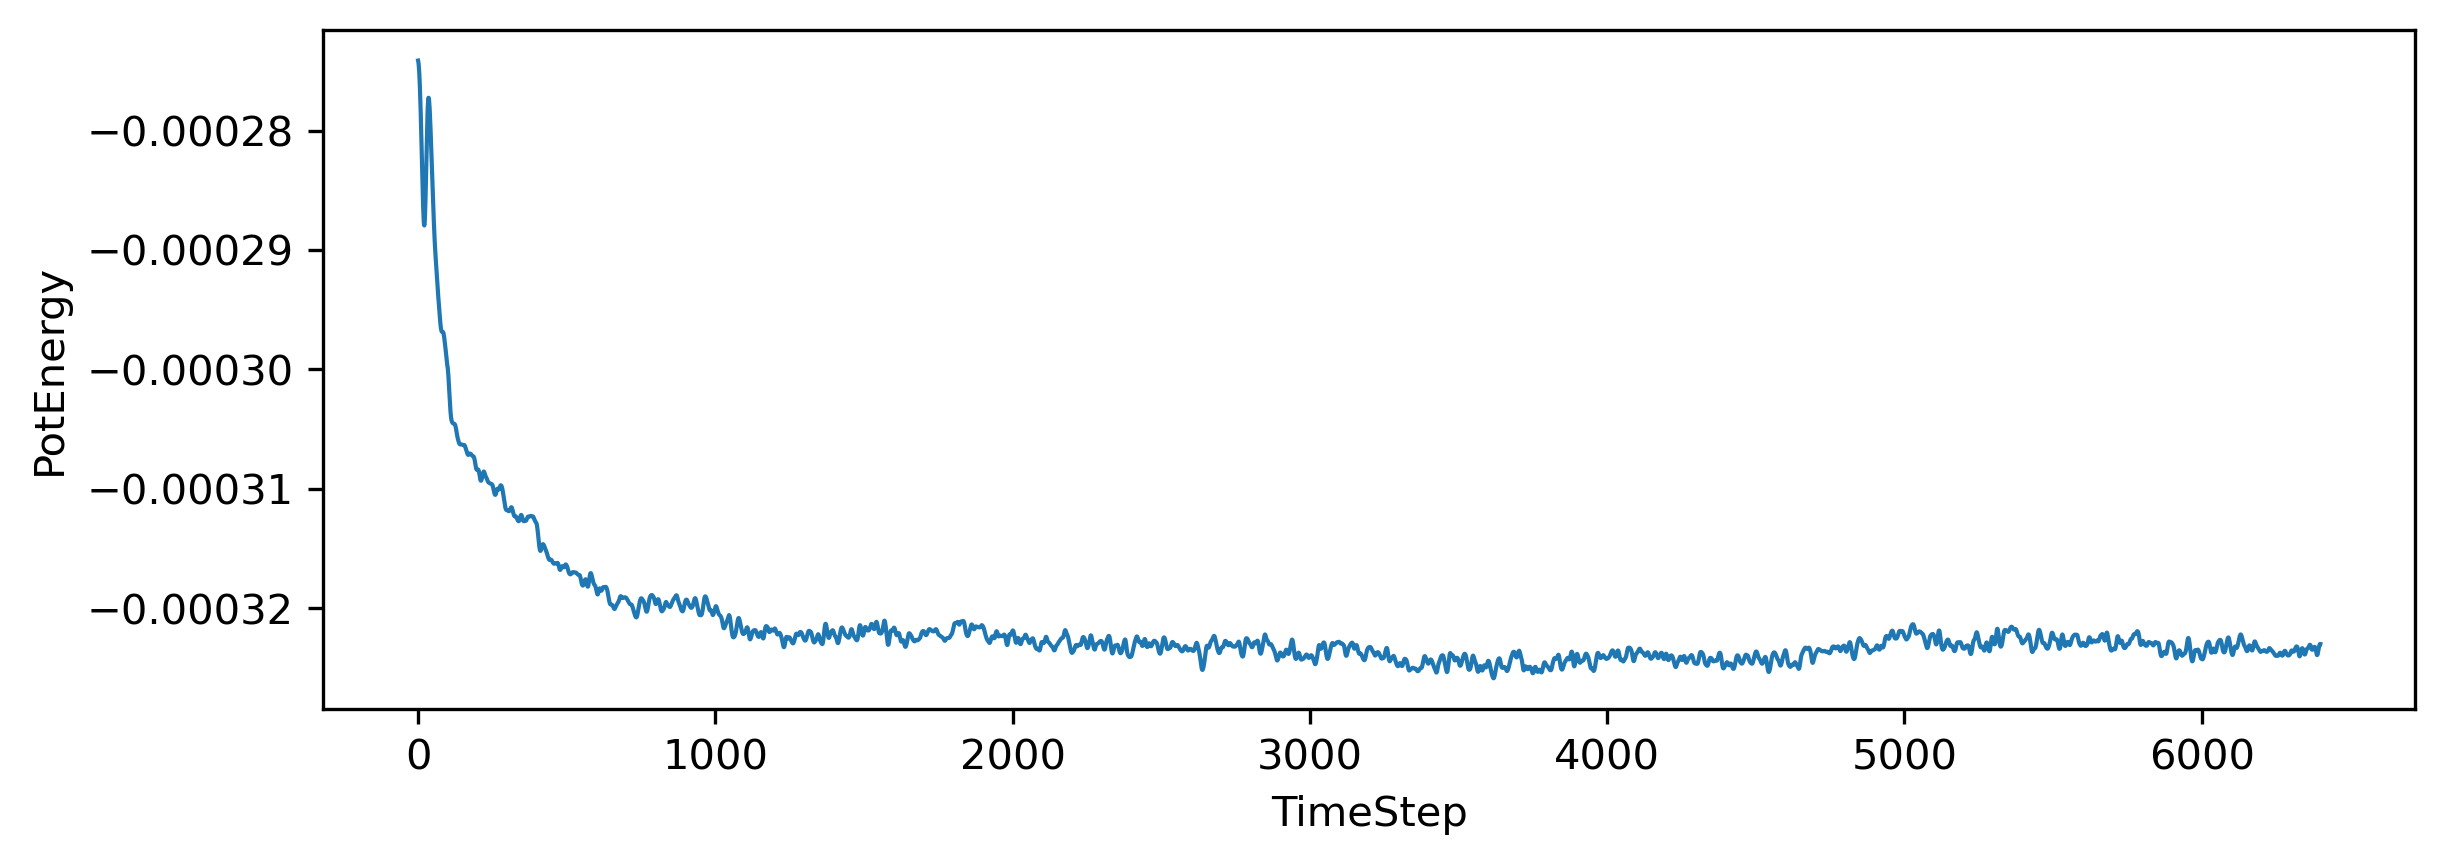

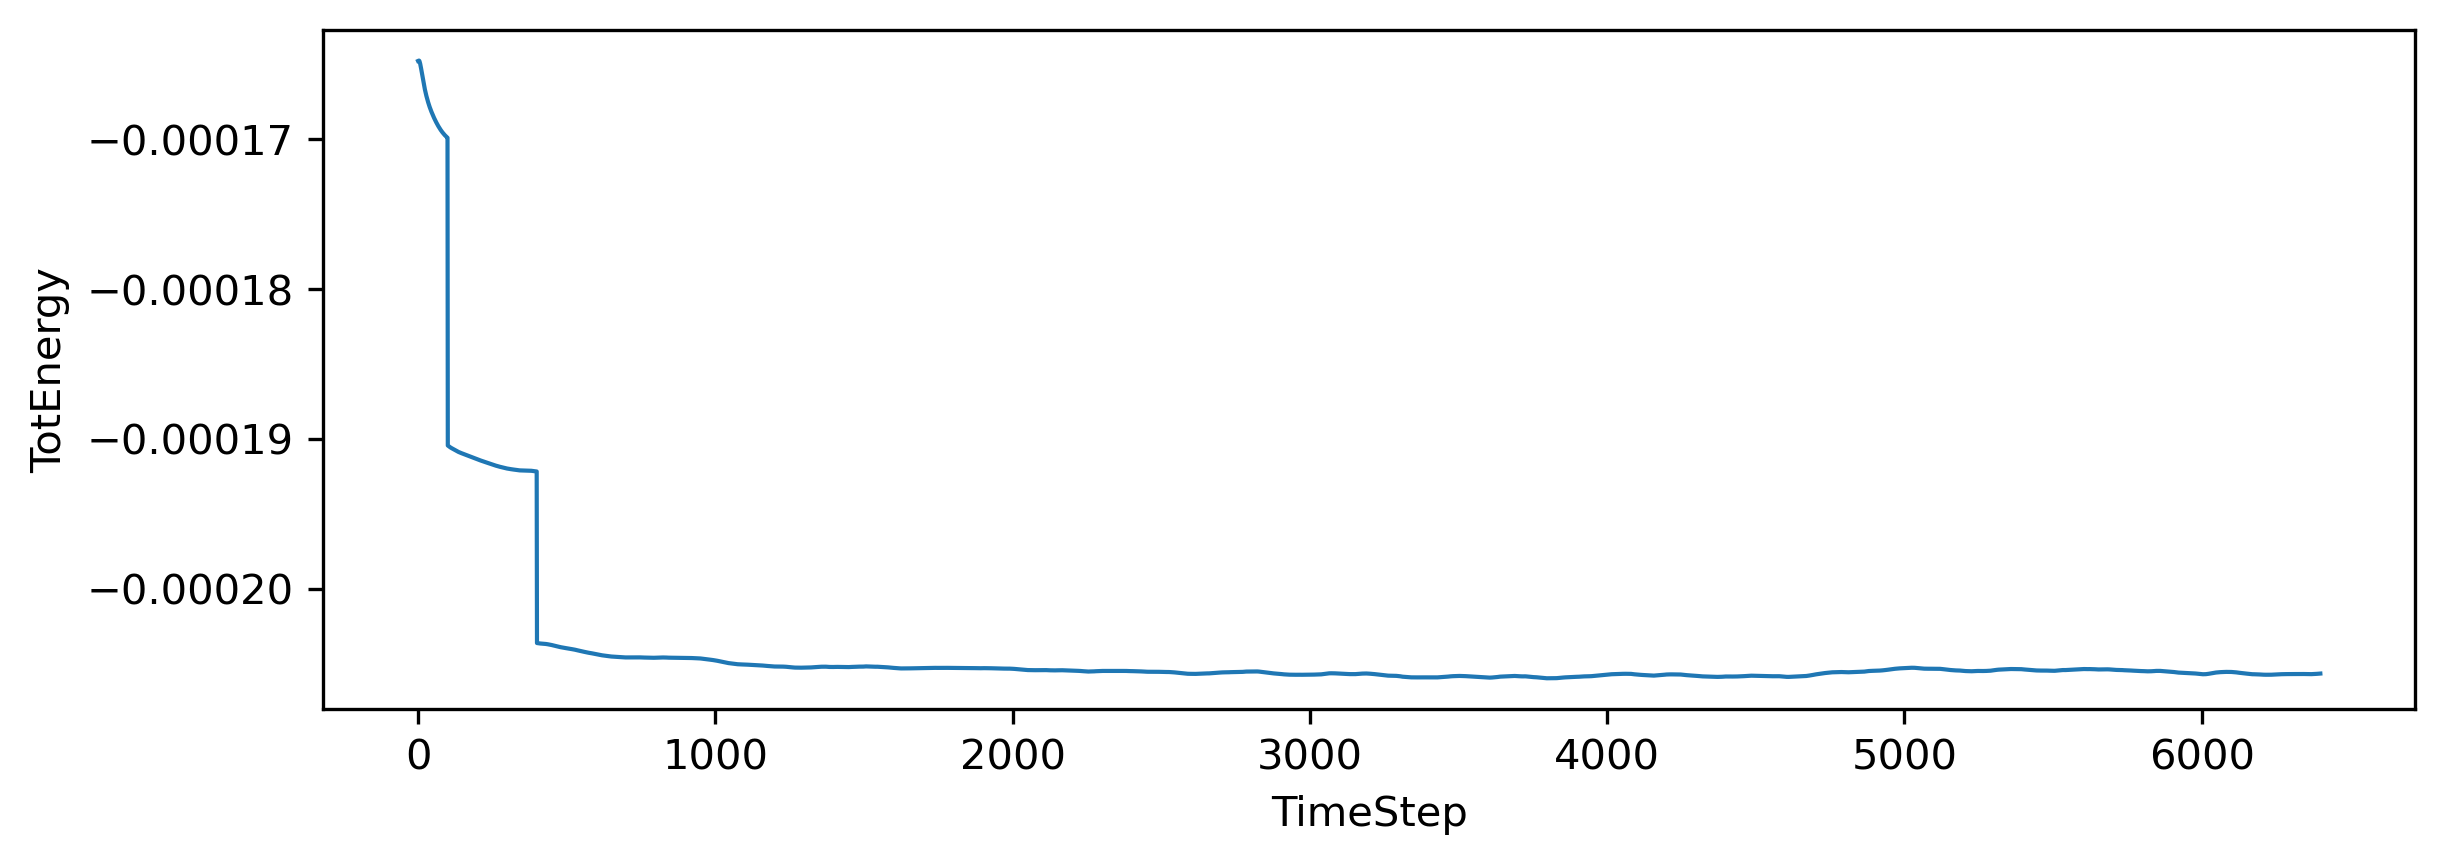

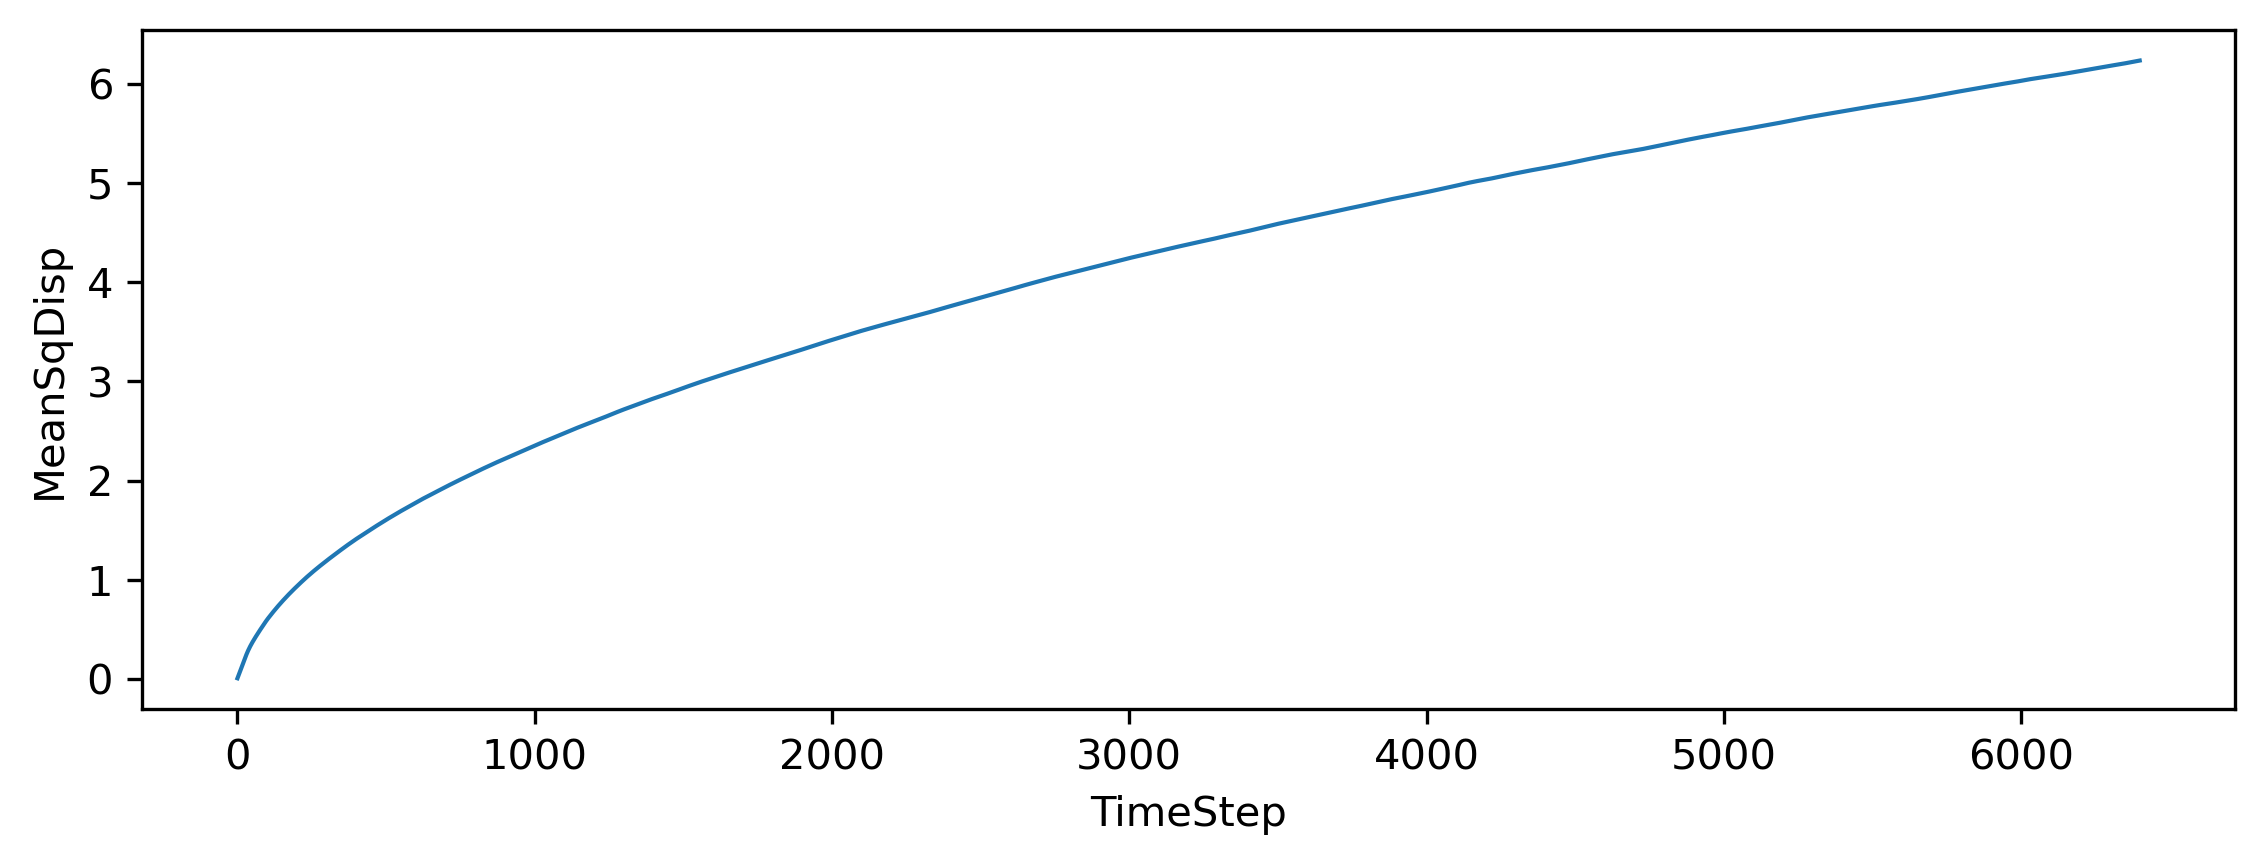

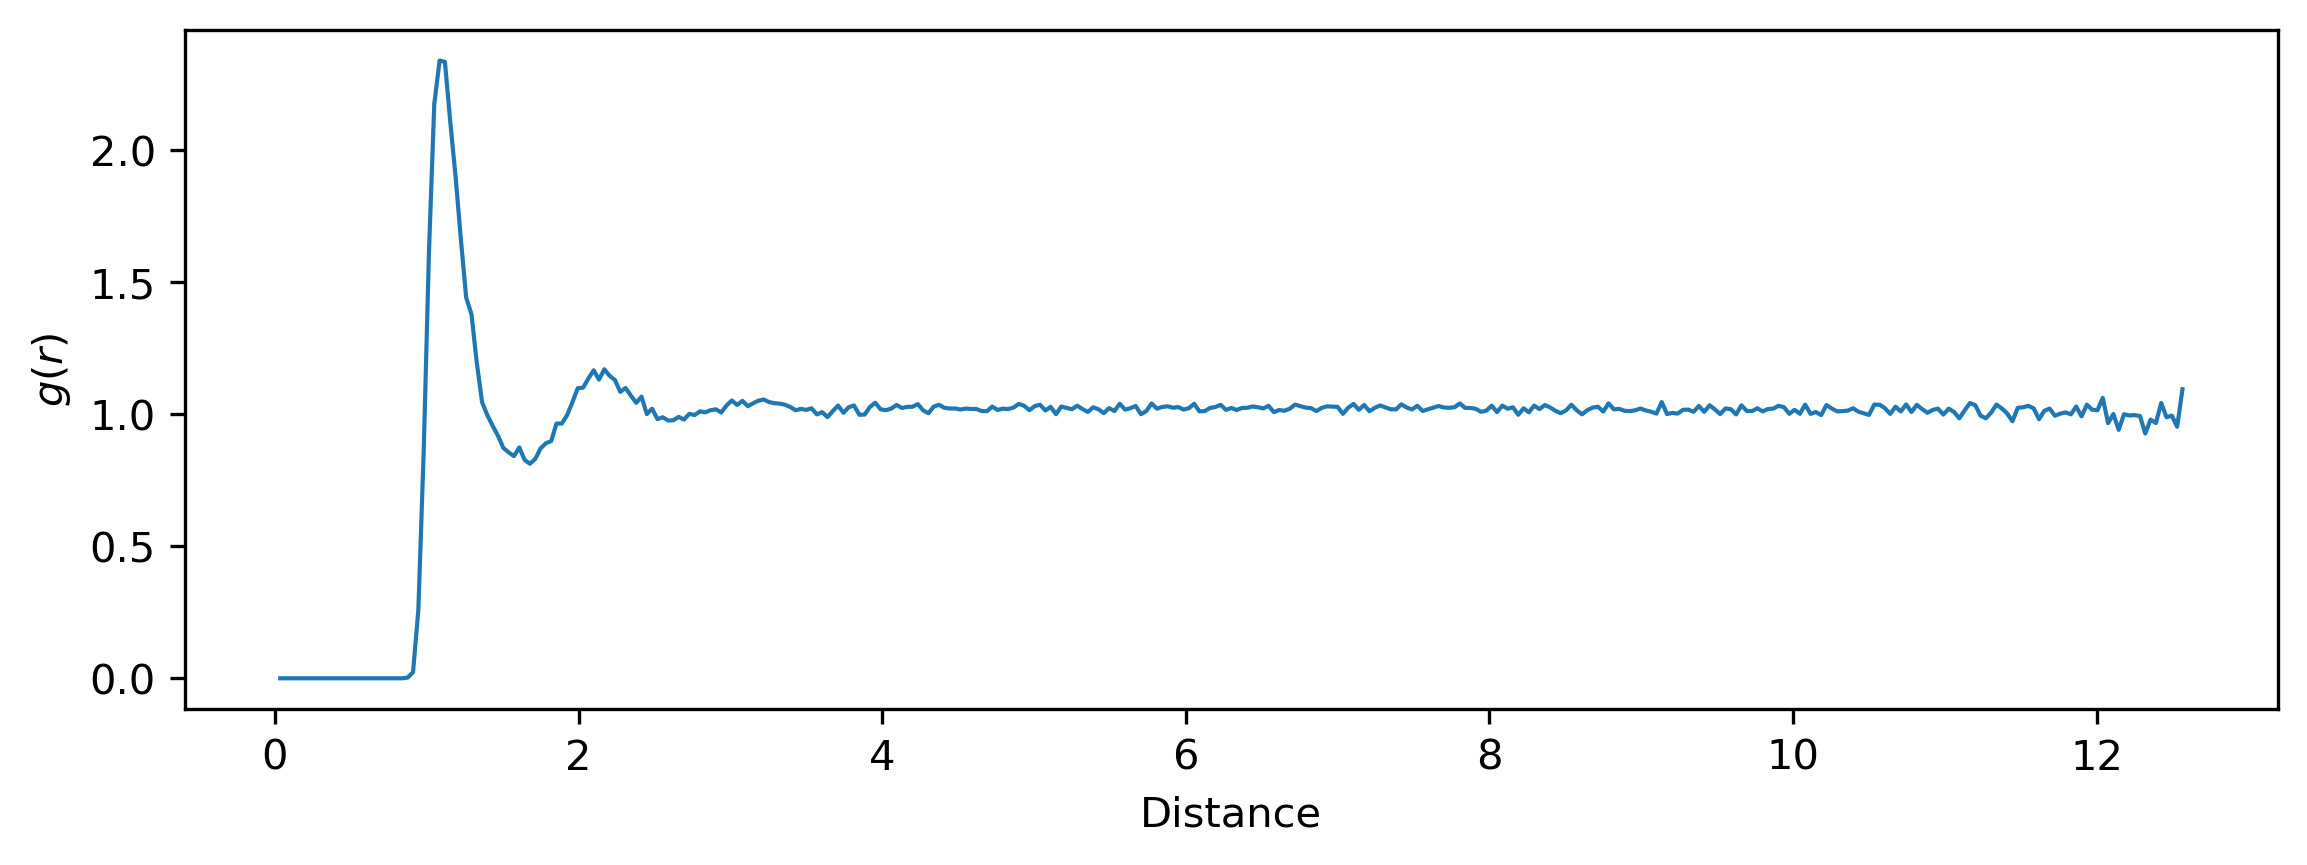

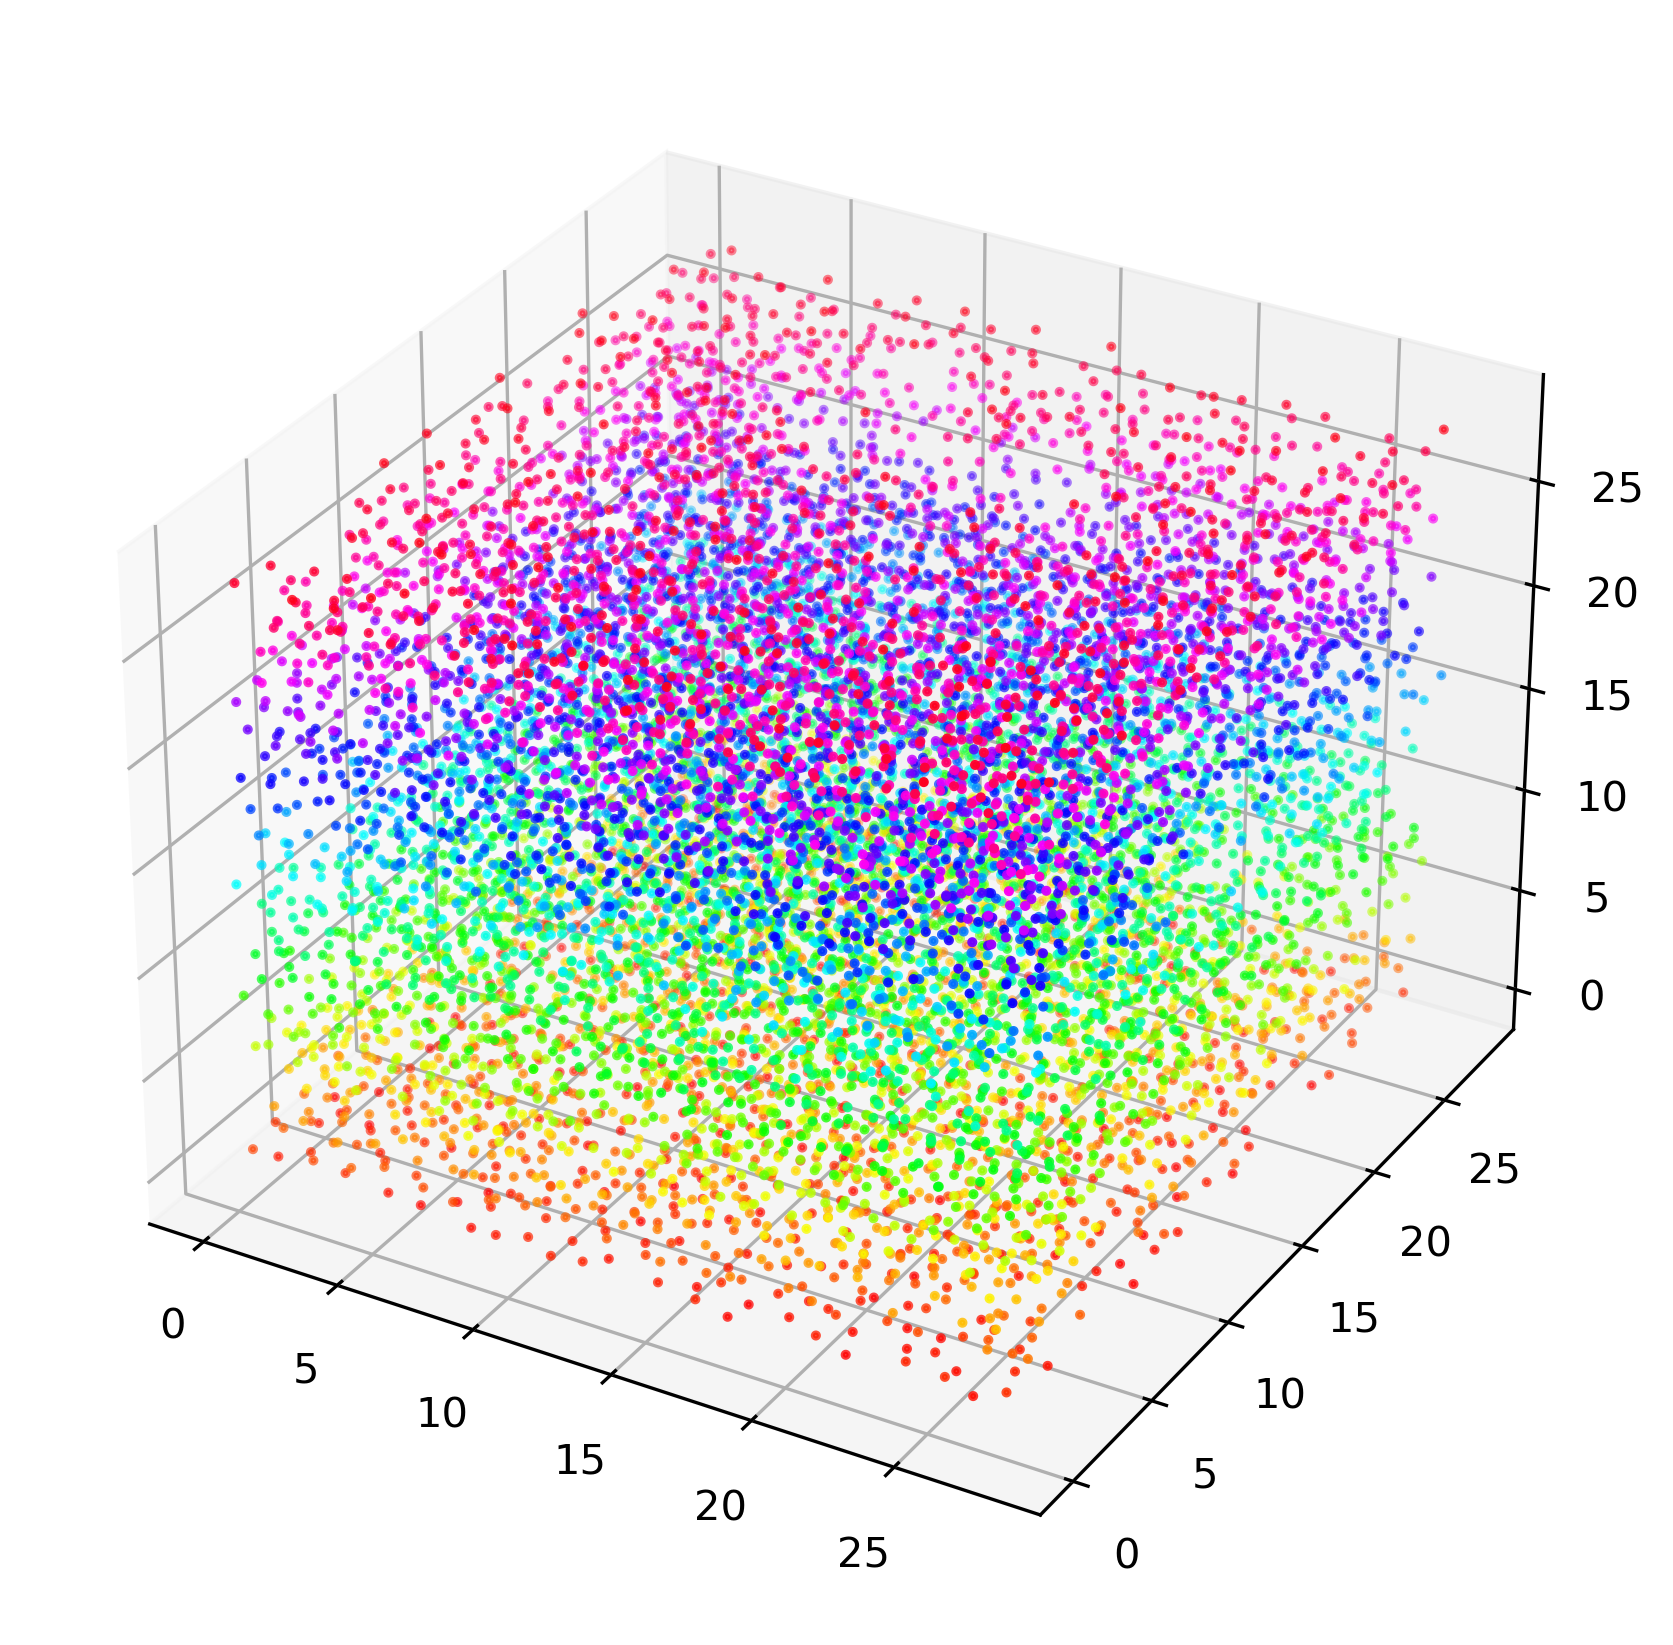

In [124]:
FIG_SIZE = (9,3)

def plot_rdf(rho_label, T_label):
    L = summary_info_data[rho_label][T_label].SideLength.iloc[0]
    g_r, radii = rdf(final_state_data[rho_label][T_label][['PosX', 'PosY', 'PosZ']].to_numpy(), dr=L/800)
    plt.figure(figsize=FIG_SIZE)
    p = sns.lineplot(x=radii, y=g_r)
    p.set(xlabel='Distance', ylabel='$g(r)$')
    plt.show()

    
def plot_speed_histogram(rho_label, T_label):
    plt.figure(figsize=FIG_SIZE)
    sns.histplot(final_state_data[rho_label][T_label]['Speed'])
    plt.show()
    
    
def plot_time_series(rho_label, T_label, dep_variable):
    """dep_variable can be ['Temp', 'PotEnergy', 'TotEnergy', 'MeanSqDisp']"""
    plt.figure(figsize=FIG_SIZE)
    sns.lineplot(data=time_series_data[rho_label][T_label][dep_variable])
    plt.show() 
    

def visualize_sim_cell(rho_label, T_label):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    final_state_slice = final_state_data[rho_label][T_label]
    ax.scatter3D(final_state_slice['PosX'],
                final_state_slice['PosY'],
                final_state_slice['PosZ'],
                c=final_state_slice['PosZ'],
                cmap='hsv',
                 s=2, )
    plt.show()
    
    ##### TODO ##### 
    # Make this function view along x and y axes to better see order
    
    
def plot_all(rho_label, T_label):
    plot_speed_histogram(rho_label, T_label)
    for var in ['Temp', 'PotEnergy', 'TotEnergy', 'MeanSqDisp']:
        plot_time_series(rho_label, T_label, var)
    plot_rdf(rho_label, T_label)
    visualize_sim_cell(rho_label, T_label)

    
def plot_E_vs_T(target_rho):
    thermo_meas_slice = thermo_meas_data.loc[abs(thermo_meas_data['Density'] - target_rho) < 0.01]
    plt.figure(figsize=FIG_SIZE)
    sns.scatterplot(x=thermo_meas_slice['Temp'], y=thermo_meas_slice['Energy'])
    plt.show()

    
### Example usage
# plot_rdf('rho_0.800', 'T_0.600')
# plot_speed_histogram('rho_0.800', 'T_0.600')
# plot_time_series('rho_0.800', 'T_0.600', 'Temp')
# visualize_sim_cell('rho_0.800', 'T_0.600')
plot_all('rho_0.500', 'T_0.800')

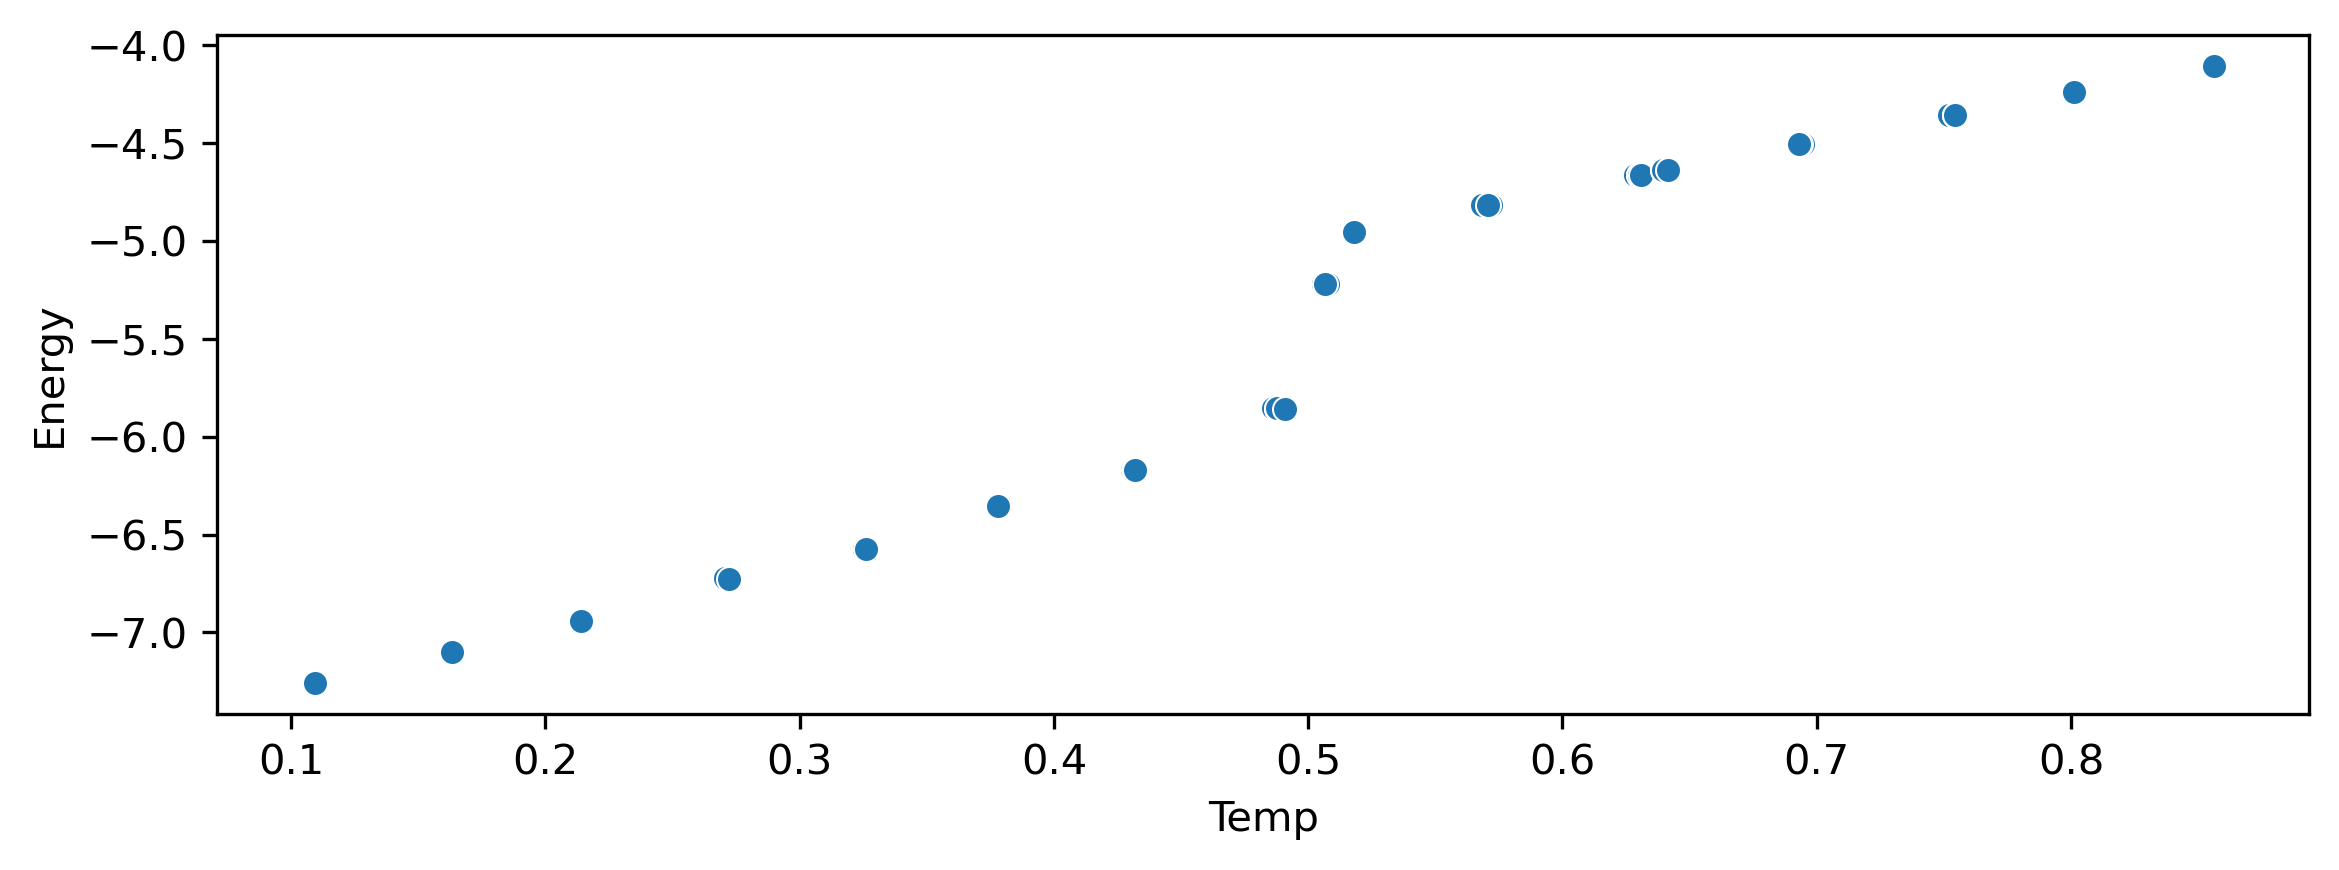

In [123]:
plot_E_vs_T(0.8) #phase transition T~0.5